# Model building

There are several top notch deep learning frameworks that would suffice for this task; but in this case we'll be using __Tensorflow__ from __Google__.  

In [1]:
# Import necessary packages.
import tensorflow as tf
from tensorflow.keras import layers, models
tf.get_logger().setLevel("ERROR")

# Important constants.
IMAGE_SIZE = 256
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 100

In [2]:
# Load the dataset with the Tensorflow data pipeline.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\ifunanyaScript\Everything\BrainTumour_DiagnosisApp\data\clean_dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = (BATCH_SIZE),
)

Found 3000 files belonging to 2 classes.


The dataset is loaded as batches specified by the "batch_size" parameter. In this case, 3000 images batched into sizes of 8. Thus, 375 batches and that would be the length of the dataset.

In [3]:
len(dataset)

375

When one wants to train a model with a particular dataset, the normal practice is to split said dataset into separate chunks; particularly a training chunk and a testing chunk. The purpose of splitting the data is for evaluation purposes after training the model.  
Most times, ML folks use __scikit-learn's__ ___train_test_split___. In this case, we'll use the ___take___ and ___skip___ attributes of the dataset object which allows us to grab a portion of the dataset by batches.  

The training chunk is always a lot larger that the validation chunk and testing chunk, so that the model is trained on as much data as possible. We'll set aside for training, validation and testing; 80%, 10%, 10% respectively.

In [4]:
train_size = 0.8
print(f"The training dataset should be {int(len(dataset)*train_size)} batches")

The training dataset should be 300 batches


In [5]:
# Takes first 300 batches of the dataset
train_ds = dataset.take(300)
len(train_ds)

300

In [6]:
# Remaining data after the training chunk.
remnant = dataset.skip(300)
len(remnant)

75

In [7]:
val_size = 0.1
print(f"The validation dataset should be {int(len(dataset)*val_size)} batches")

The validation dataset should be 37 batches


In [8]:
# Takes the first 37 batch of the remaining data.
val_ds = remnant.take(37)
len(val_ds)

37

In [9]:
# Takes all the data after the first 37 batches.
test_ds = remnant.skip(37)
len(test_ds)

38

All of these snippets can be wrapped in a simple function.

In [10]:
def chunking(dataset, train_split=0.8, validation_split=0.1, test_split=0.1, shuffle=True, buffer=1000):
    """
    The purpose of this function is to split a dataset into the necessary chunks and return
    said chunks accordingly.
    
    A dataset is passed as an argument and the partitions are made with the predefined split sizes.
    One can also alter the split sizes by changing the values while calling the function.
    """
    
    number_of_batches = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(buffer, seed=321)
    
    train_size = int(train_split*number_of_batches)
    validation_size = int(validation_split*number_of_batches)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(validation_size)
    test_ds = dataset.skip(train_size).skip(validation_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = chunking(dataset)
print(f"""The dataset of 94 batches was chunked as follows: 
{len(train_ds)} batches for the Training dataset, 
{len(val_ds)} batches for the Validation dataset and, 
{len(test_ds)} batches for the Testing dataset.""")

The dataset of 94 batches was chunked as follows: 
300 batches for the Training dataset, 
37 batches for the Validation dataset and, 
38 batches for the Testing dataset.


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Caching is used to improve data retrieval performance by reducing the need to access underlying storage.  
In short, the dataset is cached in memory. This reduces training time because there will be no need open files and read images during each epoch.. The next epochs will reuse the data cached by the cache transformation.

In [13]:
# Layers for data_augmentation, resizing and rescaling.
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomContrast(0.5),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.4)
])

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

As always, feature engineering/extraction is an essential step to training a reliably accurate model. However, one might ask how do you extract features when training a CNN. Well, the convolution filters in CNN hovers through the entire image and extracts features from the image. This is actually a rather simple mathematical process if you consider it.   
We'll stack several convolutional layers together to grab enough features as possible. Also reducing dimensionality is very important so as to keep the trainable parameters(weights) concise and reduce training time, hence, we use Maxpooling.  
After the convolutional layers we'll add a fully connected dense layer containing an arbitrary number of neurons and a final output layer activated by a sigmoid function.

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu", ),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

# Initialises the model.
model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (8, 256, 256, 3)          0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

Yowza!!!<br> 
We have to train over 155,900 weights.<br>
This will take a pretty long time using a CPU.<br>
Patience is a virtue.

As we know, backward propagation is one of two fundamental steps in training an __NN__. We'll use Adam optimizer for backward propagation.<br>
Since it is binary classification __i.e__, no tumour[0] or tumour[1], we'll use BinaryCrossentropy to calculate the loss of the model's prediction compared to the actual labels.<br>
Then we can track our model's performance with an accuracy metric.


__NB:__ Backward propagation is a method sort of differencial calculus where we calculate the gradient of the loss function with respect to the parameters(weights and biases). Then we update said weights and biases according to minimise the loss.

In [16]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

We train the model by fitting it to the training dataset and we validate its performance with the validation dataset.

In [17]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/100
300/300 [==============================] - 378s 1s/step - loss: 0.6890 - accuracy: 0.5333 - val_loss: 0.6500 - val_accuracy: 0.6858
Epoch 2/100
300/300 [==============================] - 278s 917ms/step - loss: 0.6613 - accuracy: 0.6221 - val_loss: 0.5806 - val_accuracy: 0.7095
Epoch 3/100
300/300 [==============================] - 8601s 29s/step - loss: 0.6270 - accuracy: 0.6608 - val_loss: 0.6043 - val_accuracy: 0.6791
Epoch 4/100
300/300 [==============================] - 229s 765ms/step - loss: 0.5901 - accuracy: 0.6921 - val_loss: 0.5196 - val_accuracy: 0.7399
Epoch 5/100
300/300 [==============================] - 227s 756ms/step - loss: 0.5961 - accuracy: 0.6933 - val_loss: 0.5210 - val_accuracy: 0.7601
Epoch 6/100
300/300 [==============================] - 228s 760ms/step - loss: 0.5673 - accuracy: 0.7183 - val_loss: 0.5007 - val_accuracy: 0.7635
Epoch 7/100
300/300 [==============================] - 226s 752ms/step - loss: 0.5454 - accuracy: 0.7312 - val_loss: 0.485

300/300 [==============================] - 235s 783ms/step - loss: 0.1485 - accuracy: 0.9483 - val_loss: 0.0980 - val_accuracy: 0.9595
Epoch 57/100
300/300 [==============================] - 231s 770ms/step - loss: 0.1651 - accuracy: 0.9350 - val_loss: 0.1231 - val_accuracy: 0.9595
Epoch 58/100
300/300 [==============================] - 232s 774ms/step - loss: 0.1340 - accuracy: 0.9488 - val_loss: 0.0944 - val_accuracy: 0.9662
Epoch 59/100
300/300 [==============================] - 231s 770ms/step - loss: 0.1357 - accuracy: 0.9496 - val_loss: 0.0914 - val_accuracy: 0.9662
Epoch 60/100
300/300 [==============================] - 231s 772ms/step - loss: 0.1324 - accuracy: 0.9533 - val_loss: 0.1411 - val_accuracy: 0.9493
Epoch 61/100
300/300 [==============================] - 231s 770ms/step - loss: 0.1321 - accuracy: 0.9508 - val_loss: 0.0866 - val_accuracy: 0.9730
Epoch 62/100
300/300 [==============================] - 231s 771ms/step - loss: 0.1369 - accuracy: 0.9475 - val_loss: 0.1261 

We'll carry out a final evaluation of the model to see its general performance.<br>
We'll do this using the test dataset; a dataset it has not seen prior.

In [18]:
scores = model.evaluate(test_ds)

38/38 [==============================] - 105s 983ms/step - loss: 0.0702 - accuracy: 0.9770


Pretty good performance. Approximately 98% accuracy.  
<br>
<br>
When one fits a model, the process returns a few items; that which we assigned to the ___history___ variable. Let's take a look.

In [19]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 300}

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

These are the keys the training process displayed. Since we ran 100 epochs, each of these keys contain 100 items.

In [21]:
print(len(history.history['accuracy']))
print(history.history['accuracy'])

100
[0.5333333611488342, 0.622083306312561, 0.6608333587646484, 0.6920833587646484, 0.6933333277702332, 0.7183333039283752, 0.731249988079071, 0.7454166412353516, 0.7666666507720947, 0.7604166865348816, 0.7712500095367432, 0.78125, 0.7995833158493042, 0.7987499833106995, 0.8120833039283752, 0.8341666460037231, 0.8358333110809326, 0.8424999713897705, 0.8633333444595337, 0.8612499833106995, 0.8675000071525574, 0.8866666555404663, 0.8833333253860474, 0.8929166793823242, 0.8974999785423279, 0.8983333110809326, 0.9070833325386047, 0.9087499976158142, 0.902916669845581, 0.9195833206176758, 0.9212499856948853, 0.9141666889190674, 0.9145833253860474, 0.92166668176651, 0.9300000071525574, 0.9175000190734863, 0.92166668176651, 0.9266666769981384, 0.9337499737739563, 0.9262499809265137, 0.9320833086967468, 0.9354166388511658, 0.9375, 0.9266666769981384, 0.9329166412353516, 0.9358333349227905, 0.9424999952316284, 0.9387500286102295, 0.9479166865348816, 0.9354166388511658, 0.9437500238418579, 0.944

As we can see the first value corresponds with the first accuracy our model achieved in the first epoch. 
  
  
I would like to plot the values of those keys to illustrate how the model got better over each epoch.

In [22]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

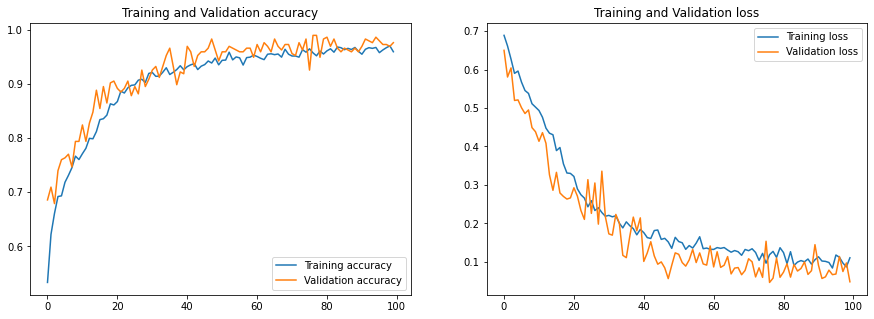

In [28]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label="Training accuracy")
plt.plot(range(EPOCHS), val_accuracy, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training loss")
plt.plot(range(EPOCHS), val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation loss")

plt.show()

Beautiful!  
From these line plots we can confidently say a 100 epochs wasn't needed. Perhaps 75 should have sufficed.  
It's interesting how we can visualise how accuracy increases and loss decreases.  
  
  
  
### Some extracurricular testing
Let's play with the model...

Predicting this image...
Actual label: tumour
1/1 [==============================] - 1s 1s/step


TypeError: only integer scalar arrays can be converted to a scalar index

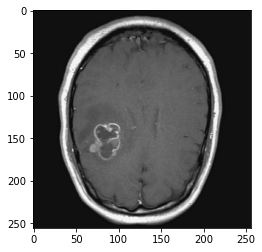

In [38]:
import numpy as np
label_names = dataset.class_names

for images_batch, labels_batch in test_ds.take(1):
    image = images_batch[0].numpy().astype("uint8")
    label = labels_batch[0].numpy()
    
    print("Predicting this image...")
    plt.imshow(image)
    print(f"Actual label: {label_names[label]}")
    
    predictions = (model.predict(images_batch) > 0.5).astype("int32")
    print(f"predicted label: {label_names[predictions[0]]}")